# CIFAR10 Data Augmentation Demo
The purpose of this notebook is to demonstrate the positive impact that data-augmentation can have on a machine learning model.  
In general, data augmentation is taking your data, and adding noise to it to produce additional training data. 
In signal processing applications you might add some sort of random or gaussian noise, where in computer vision / image classification work you might transform the training images with rotation, translation, etc. 
Regardless of your modality, the principle is the same: to increase the size of your training dataset, so it can generalize better to new data. 

"*We don’t have better algorithms than anyone else; we just have more data*" - Google Chief Scientist, 2011 

I quite like this quote, as it really makes clear the important of data in any data driven approach like deep learning.  
In a deep learning project, you will spend the vast majority of your time on data cleaning, preprocessing, feature engineering, and with what I will demonstrate today, data augmentation. 

Now to demonstrate the power of data augmentation in theory, I will assign rough factors to each operation based on how they affect the augmented data space. 

In [ ]:
import numpy as np
# clearly each type of flip doubles the potential data
horizontal_flip = 2
vertical_flip = 2
# lets lowball this, we assume there are 5 angles at which you rotate the each image
rotation = 5
# lets assume you either lower, raise, or maintain the brightness
brightness_modulation = 3
# A conservative lowball, you shift left, right, or be zero
horizontal_shift = 3
# same as above but up, down, same
vertical_shift = 3

In [ ]:
total_augmentation_factor = np.array([
                                      horizontal_flip, 
                                      vertical_flip, 
                                      rotation,
                                      brightness_modulation, 
                                      horizontal_shift, 
                                      vertical_shift
]).prod()
print("Therefore, we create an augmented data space with {} times more data. ".format(total_augmentation_factor))

Therefore, we create an augmented data space with 540 times more data. 


#### Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
# we will load cifar from online repo for easy reprocibility
from tensorflow.keras.datasets import cifar10
import pandas as pd

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

## Load Data

In [ ]:
# CIFAR10 is nice because it is included in tensoflow datasets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
# taking a peek at our training inputs
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# taking a peek at our training outputs
y_train.shape

(50000, 1)

Since we want to do image *classification*, we want to predict which category the image belongs to. Currently our y_train data is a 1D array of integers representing categories, but we want to transform this into an n dimensional vector for each image, where
n is the number of categories and the vector is filled with zeros except for a single 1 which indicates that the corresponding item in x is in that category.  

For example if n=3, [1,0,2...] --> [ [0,1,0], [1,0,0], [0,0,1] ]

**one-hot encoding** is the process of doing this transformation. 

In [ ]:

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

Now we see that the data has a new shape, it is an array of vectors. 

In [ ]:
y_train.shape

(50000, 10)

## Data Generators
Now we will intantiate the objects that will take in a dataset, and flow out augmented (or un-modified) data. 

In [ ]:
datagen = ImageDataGenerator() # no parameters defining data augmentation here

In [ ]:
# notice that some transformations are reasonable in some cases, and not in others. 
datagen_aug = ImageDataGenerator(zoom_range=[0.9,1.0],
                                 brightness_range=[0.8,1.2],
                                 rotation_range=10,
                                 horizontal_flip=True,
                                 #vertical_flip=True,
                                 #height_shift_range=0.1,
                                 #width_shift_range=0.1
                                )

An important note is to not destroy the quality of the images, as if you can no longer tell what an image is you sould not expect your model to be able to. 

We will set up a train and a test iterable object that use the baseline datagen object, and then we will setup an augmented train iterable object that will use the augmented data generator. 

In [ ]:
train_generator = datagen.flow(x_train, y_train)

In [ ]:
test_generator = datagen.flow(x_test, y_test)

In [ ]:
train_aug_gen = datagen_aug.flow(x_train, y_train)

In [ ]:
train_generator.next()[1].shape

(32, 10)

You may notice I did not create any augmented test data generators, this is because your model is not trying to learn from the test set. The test set is where you want to get a measure of how your model performs on new, real world data. So giving it un-augmented data is the best test. 

## Visualize Some Input Data

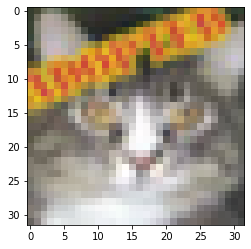

In [ ]:
plt.imshow(train_generator.next()[0][5].astype('uint32'))

Let's see some examples of unmodified training images

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


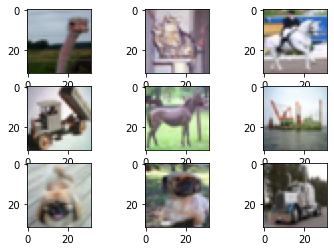

In [ ]:
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = train_generator.next()[0]
#     print(batch.shape)
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8').reshape((32,32,3))
    print(image.shape)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

Let's see some examples of augmented training images

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


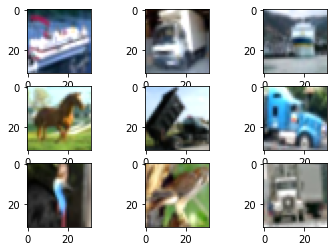

In [ ]:

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = train_aug_gen.next()[0]
#     print(batch.shape)
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8').reshape((32,32,3))
    print(image.shape)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

The differences are subtle, just enough to introduce some additional variation without obscuring what it should be classified as. 

Since we are going to create multiple of the same model, let's define a function that contains our model architecture.  
Please note that I am not intending to create an exceptional model that will achieve state of the art CIFAR10 performance.  
In fact, I want to deliberately leave performance on the table so we can see the positive impact of data augmentation. 

In [ ]:
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  return model

## Lets train a model without data augmentation

In [ ]:
model = create_model()

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator=train_generator,
                    validation_data = test_generator,
                   epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 4.5205 - accuracy: 0.2780 - val_loss: 1.7789 - val_accuracy: 0.3575
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6024 - accuracy: 0.4270 - val_loss: 1.5591 - val_accuracy: 0.4608
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3742 - accuracy: 0.5119 - val_loss: 1.3295 - val_accuracy: 0.5304
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2293 - accuracy: 0.5637 - val_loss: 1.1943 - val_accuracy: 0.5844
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1147 - accuracy: 0.6084 - val_loss: 1.1145 - val_accuracy: 0.6110
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0145 - accuracy: 0.6453 - val_loss: 1.1093 - val_accuracy: 0.6122
Epoch 7/20
1563/1563 [==============================] - 8s 5

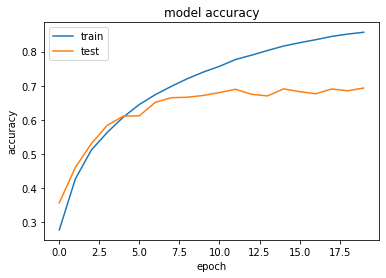

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Now lets try again, with data augmentation

In [ ]:
model2 = create_model()

In [ ]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit_generator(generator=train_aug_gen,
                    validation_data = test_generator,
                   epochs=40)

Epoch 1/40
1563/1563 [==============================] - 35s 23ms/step - loss: 4.5593 - accuracy: 0.3212 - val_loss: 1.6124 - val_accuracy: 0.4107
Epoch 2/40
1563/1563 [==============================] - 35s 23ms/step - loss: 1.4954 - accuracy: 0.4596 - val_loss: 1.4365 - val_accuracy: 0.4913
Epoch 3/40
1563/1563 [==============================] - 35s 23ms/step - loss: 1.3437 - accuracy: 0.5203 - val_loss: 1.2682 - val_accuracy: 0.5518
Epoch 4/40
1563/1563 [==============================] - 36s 23ms/step - loss: 1.2238 - accuracy: 0.5648 - val_loss: 1.1663 - val_accuracy: 0.5835
Epoch 5/40
1563/1563 [==============================] - 36s 23ms/step - loss: 1.1251 - accuracy: 0.6047 - val_loss: 1.1247 - val_accuracy: 0.6069
Epoch 6/40
1563/1563 [==============================] - 35s 23ms/step - loss: 1.0540 - accuracy: 0.6317 - val_loss: 1.0656 - val_accuracy: 0.6318
Epoch 7/40
1563/1563 [==============================] - 36s 23ms/step - loss: 0.9989 - accuracy: 0.6512 - val_loss: 1.0333 -

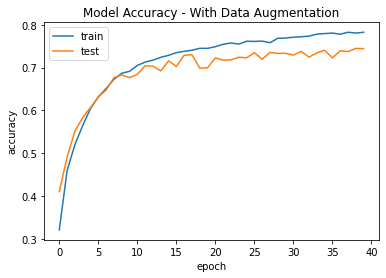

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy - With Data Augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusions
We see that in the first model, the training accuracy climbs higher away from the validation accuracy as the model trains further, this is a clear indication that our model is overfitting to the training set.  
However in the second model, we see thar the validation accuracy stays close to the training accuracy and continues to improve with training. This is a good indication that we have introduced enough variation into our training set to handle more of the variation in our test set. 

I hope you have enjoyed this short introduction to data augmentation, and you can see the value in using data augmentation in your future work. 